# Simulations

A significant part of the [Stochastic Matching package](https://balouf.github.io/stochastic_matching/index.html) is devoted to simulations, allowing to check the practical value of theoretical results and to explore new conjectures.

First, some settings that should apply to all our simulations.

:::note
The *refresh* parameter below tells if the simulation should run if a simulation file already exists.
:::

In [1]:
refresh = False
n_steps = 10**10
common = {
        "n_steps": n_steps,
        "max_queue": 50000,
        "seed": 42,
}

## Approaching vertices

### Preparation

First, we define the set of simulations we want to run. Let's make a small mixer of common and specific parameters.

In [2]:
import numpy as np
from stochastic_matching import XP, Iterator, evaluate
from multiprocess import Pool
from numba import njit

def xp_builder(common, specific):
    return sum([XP(name=k, **common, **v) for k, v in specific.items()])

Prepare specific parameters for each policy.

In [3]:
k_range = Iterator("k", [2**i for i in range(14)])
e_range = Iterator("epsilon", np.logspace(-3, 0, 10), name="ϵ")
b_range = Iterator("beta", np.logspace(-3, 1, 10), name="β")
def exp_fad(x):
    return njit(lambda t: (t+1)**x)
v_range = Iterator("fading", [exp_fad(x) for x in np.linspace(0., 1., 10)], name="V")

specific = {
    'k-filtering': {'simulator': "longest", 'forbidden_edges': True, 
                    'iterator': k_range},
    'EGPD': {'simulator': "virtual_queue", 
             'iterator': b_range},
    "ϵ-filtering": {'simulator': "e_filtering", 
                    'iterator': e_range},
    "EGPD+": {'simulator': "virtual_queue", 'alt_rewards': 'gentle', 
              'iterator':  b_range},
    "CRPD": {'simulator': 'constant_regret', 
             'iterator': v_range},
    "Taboo": {'simulator': 'longest', 'forbidden_edges': True}
           }

Finally, a display function with a few options.

In [4]:
import matplotlib.pyplot as plt

name_relabelling = {'Taboo': '$\\Phi_{E^*}$'}
def display_res(res, view="loglog", x_max=None, y_min=10**-8, y_max=None):
    if view == "loglog":
        plot = plt.loglog
    elif view == "logx":
        plot = plt.semilogx
    else:
        raise ValueError(f"{view} is not a recognized display view.")
    names = [k for k in res] 
    colors = {k: v for k, v in zip(names, 
                                   plt.rcParams['axes.prop_cycle'].by_key()['color'])}
    for k in sorted(names, key=lambda k: -np.average(res[k]['regret'])):
        v = res[k]
        name = name_relabelling.get(k, k)
        delay, regret = np.array(v["delay"]), np.array(v["regret"])
        if isinstance(v["delay"], list):
            mask = delay > 0
            plot(np.abs(delay[mask]), np.abs(regret[mask]), marker="o", 
                 label=name, color=colors[k])
        else:
            if y_max is None:
                plot([delay], [regret], marker="o", label=name, color=colors[k])
            else:
                plot([delay, delay], [y_min, y_max], '--', label=name, color=colors[k])
                
    plt.ylabel("Regret")
    plt.xlabel("Delay")
    if view == "logx":
        plt.ylim([0, None])
    plt.xlim([None, x_max])
    if y_max:
        plt.ylim([y_min, y_max])
    plt.legend()
    plt.show()

### Diamond

#### Injective-only vertex

Let's reach an injective-only vertex.

In [5]:
import stochastic_matching as sm
diamond = sm.CycleChain()
rewards = [1, 2.9, 1, -1, 1]
diamond.show_flow(flow=diamond.optimize_rates(rewards))

:::note
The rewards are adversarial here: the largest reward corresponds to a taboo edge.
:::

Let us compute the delay/regret trade-offs and display the results.

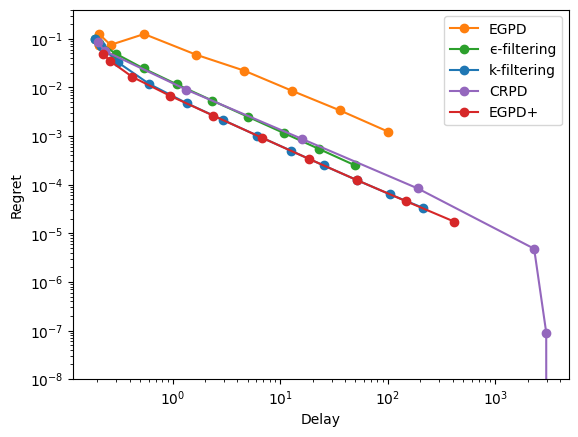

In [6]:
xps = xp_builder({'model': diamond, 'rewards': rewards, **common}, specific)
with Pool() as p:
    res = evaluate(xps, pool=p, cache_name="diamond-injective", 
                   cache_overwrite=refresh)
display_res(res, y_max=.4)

:::important

A simulation can only provide a finite-horizon estimate of the long-term behavior of a policy. In particular, it will always yield a finite delay even for policies that are proven to be unstable, i.e. those that have infinite long-term delay.

This explains why some of the policies considered here seem to achieve finite delay and zero rate-regret (that is, constant global-regret) in simulations.

For injective-only vertices, unstability stems from arrival deviations that behave roughly like an unbiased random walk, with magnitude on the order of $\sqrt(T)$, where $T$ is the number of time steps simulated. If $\sqrt(T)$ is small relative to the typical long-term delay of a policy (which is always the case for unstable policies), the trade-off between regret and delay cannot be observed through simulations.

As a consequence, for injective-only vertices:

- The regret values observed in the far right portion of the figures should be ignored, as they reflect discrepancies between long-term and finite-horizon values.
- Simulations should be run over as many time steps as possible to broaden the parameter range over which long-term and finite-horizon estimates coincide.
:::

Take-away:

- EGPD has not a good trade-off;
- $\epsilon$-filtering and CRPD have average performance;
- $k$-filtering and EGPD+ are the best here.

#### Bijective vertex

We now change the rates and rewards so that the target is a bijective vertex.

In [7]:
diamond.rates = [4, 4, 4, 2]
rewards = [-1, 1, 1, 1, 2.9]
diamond.show_flow(flow=diamond.optimize_rates(rewards))

:::note
The rewards are even more adversarial here: the largest reward corresponds the unique taboo edge, while a live edge has a negative reward.
:::

As before, let's see the trade-offs.

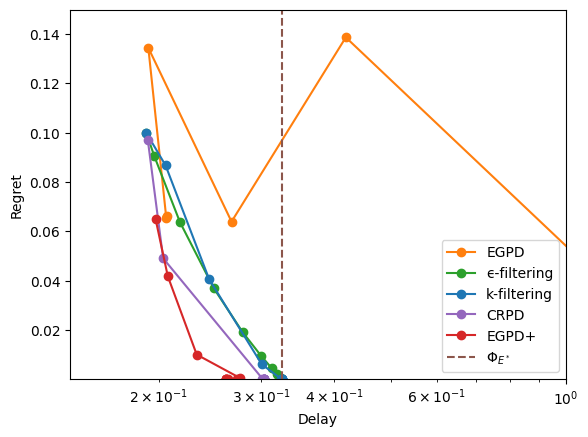

In [8]:
xps = xp_builder({'model': diamond, 'rewards': rewards, **common}, specific)
with Pool() as p:
    res = evaluate(xps, pool=p, cache_name="diamond-bijective", 
                   cache_overwrite=refresh)
display_res(res, view="logx", x_max=1, y_max=.15)

### Codomino

#### Injective-only vertex

In [9]:
codomino = sm.Codomino(rates=[2, 4, 2, 2, 4, 2])
rewards = [-1, 1, -1, 1, 4.9, 4.9, 1, -1]
codomino.show_flow(flow=codomino.optimize_rates(rewards))

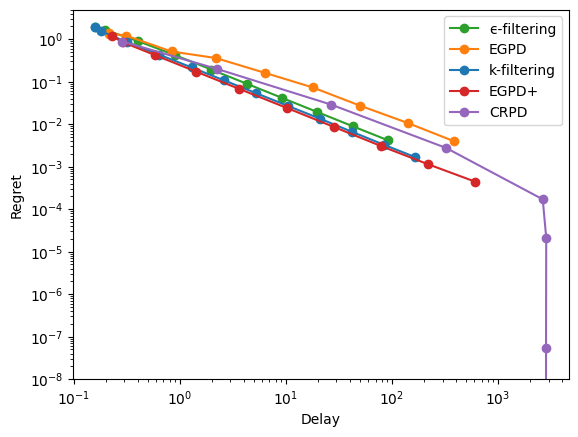

In [10]:
xps = xp_builder({'model': codomino, 'rewards': rewards, **common}, specific)
with Pool() as p:
    res = evaluate(xps, pool=p, cache_name="codomino-injective", 
                   cache_overwrite=refresh)
display_res(res, y_max=5 )

#### Bijective-only vertex

Here, we choose rewards so that all taboo edge have a positive weight, while two live edges have a negative weight.

In [11]:
codomino.rates = [4, 5, 5, 3, 3, 2]
rewards = [3.1, -1, 1,  1, -1, 0,  1, 0]
codomino.show_flow(flow=codomino.optimize_rates(rewards))

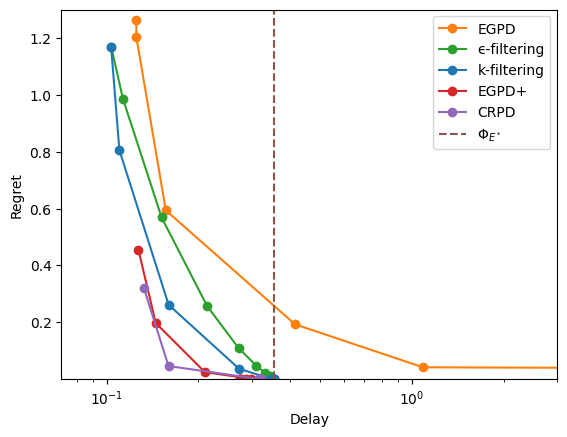

In [12]:
xps = xp_builder({'model': codomino, 'rewards': rewards, **common}, specific)
with Pool() as p:
    res = evaluate(xps, pool=p, cache_name="codomino-bijective", 
                   cache_overwrite=refresh)
display_res(res, view='logx', x_max=3, y_max=1.3)

### Larger graphs

In [13]:
n, d = 100, 20
er = sm.ErdosRenyi(n=n, d=d, seed=42)
er.m

1006

To select a vertex, we draw random rewards, which are optimized at a unique point w.h.p.

In [14]:
rewards = np.random.rand(er.m)

#### Injective-only vertex

In [15]:
vertex = er.optimize_rates(rewards)
np.sum(vertex>0)

np.int64(97)

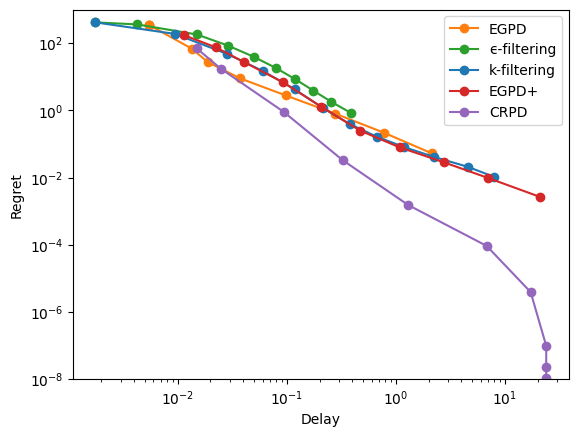

In [16]:
xps = xp_builder({'model': er, 'rewards': rewards, **common}, specific)
with Pool() as p:
    res = evaluate(xps, pool=p, cache_name="er-injective", 
                   cache_overwrite=refresh)
display_res(res, y_max=1000)

#### Bijective vertex

In [17]:
np.random.seed(42)
er.rates = er.rates + 5*np.random.rand(n)
vertex = er.optimize_rates(rewards)
np.sum(vertex>0)

np.int64(100)

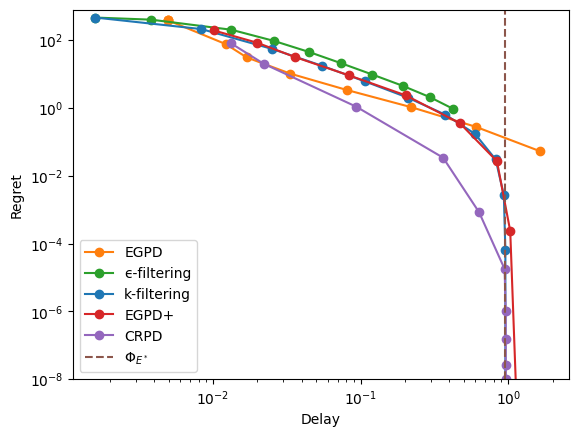

In [18]:
xps = xp_builder({'model': er, 'rewards': rewards, **common}, specific)
with Pool() as p:
    res = evaluate(xps, pool=p, cache_name="er-bijective", 
                   cache_overwrite=refresh)
display_res(res, y_max=800)

## Approaching vertices of hypergraphs

We now have hypergraphs. We need to adjust some policy settings accordingly, switching from *longest queue* to *virtual queue* to ensure stability.

In [19]:
for k in ['k-filtering', 'Taboo']:
    specific[k]['simulator'] = 'virtual_queue'
    specific[k]['alt_rewards'] = 'gentle'
specific['ϵ-filtering']['base_policy'] = 'virtual_queue'

### Abandonment

We now conside a diamond where one item class can be abandonned and where the optional solution is to abandon it entirely. As usual, we pick adversarial rewards so that the resulting vertex looks a bit counter-intuitive.

In [20]:
incidence = np.hstack([diamond.incidence, np.array([[0, 0, 0, 1]]).T])
modified_diamond = sm.Model(incidence=incidence, rates=[4, 4, 4, 2])
rewards = [-1, 1, 1, 1, 3, 2]
modified_diamond.show_flow(flow=modified_diamond.optimize_rates(rewards))

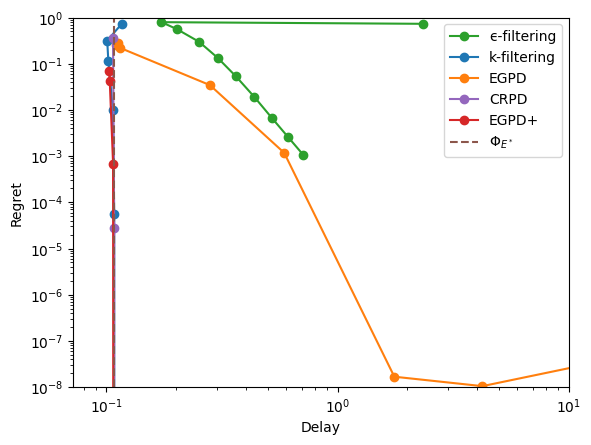

In [21]:
xps = xp_builder({'model': modified_diamond, 'rewards': rewards, **common}, specific)
with Pool() as p:
    res = evaluate(xps, pool=p, cache_name="abandonment", 
                   cache_overwrite=refresh)
display_res(res, x_max=10, y_max=1)

### Nazari & Stolyar example

See https://arxiv.org/abs/1608.01646 for details.

#### First arrival rates

In [22]:
ns19 = sm.NS19(rates=[1.2, 1.5, 2, 0.8])
rewards = [-1, -1, 1, 2, 5, 4, 7]
ns19.show_flow(flow=ns19.optimize_rates(rewards))

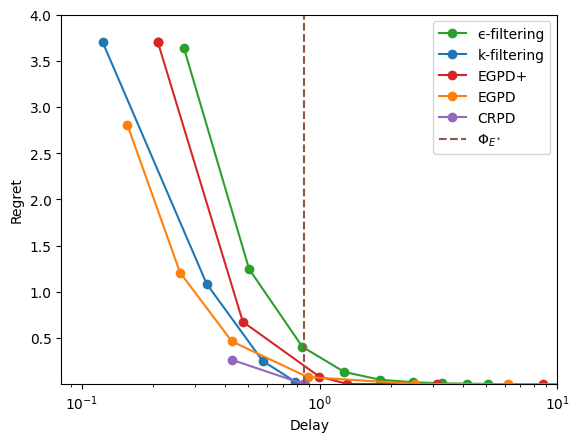

In [23]:
xps = xp_builder({'model': ns19, 'rewards': rewards, **common}, specific)
with Pool() as p:
    res = evaluate(xps, pool=p, cache_name="ns19-a", cache_overwrite=refresh)
display_res(res, view='logx', x_max=10, y_max=4)

#### Second arrival rates

In [24]:
ns19.rates = [1.8, .8, 1.4, 1]
ns19.show_flow(flow=ns19.optimize_rates(rewards))

In [25]:
xps = xp_builder({'model': ns19, 'rewards': rewards, **common}, specific)
with Pool() as p:
    res = evaluate(xps, pool=p, cache_name="ns19-b", cache_overwrite=refresh)

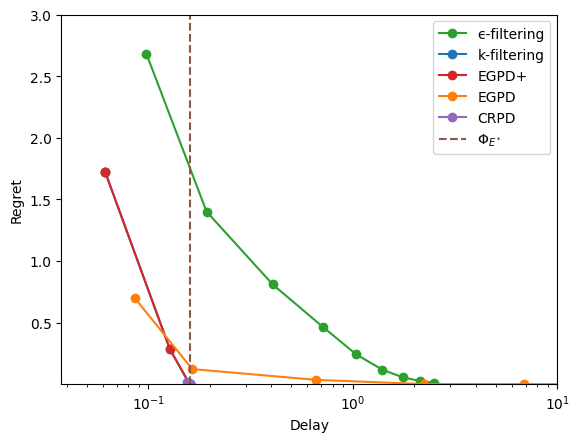

In [26]:
display_res(res, view='logx', x_max=10, y_max=3)

## Flexibility of greedy policies

### Complete graph

For complete graphs, all greedy policies are equivalent because there is never any true choice to make in that case. Let us check that by running a few greedy policies.

We will use the graph $K_4$, which has a 2-D kernel. With uniform arrival rates, its polytope is a triangle.

In [27]:
complete = sm.Complete(n=4)
complete.vertices

[{'kernel_coordinates': array([-1., -1.]),
  'edge_coordinates': array([0., 0., 3., 3., 0., 0.]),
  'null_edges': [0, 1, 4, 5],
  'bijective': False},
 {'kernel_coordinates': array([-1.,  2.]),
  'edge_coordinates': array([3., 0., 0., 0., 0., 3.]),
  'null_edges': [1, 2, 3, 4],
  'bijective': False},
 {'kernel_coordinates': array([ 2., -1.]),
  'edge_coordinates': array([0., 3., 0., 0., 3., 0.]),
  'null_edges': [0, 2, 3, 5],
  'bijective': False}]

For the comparison, we will consider the following greedy policies:

In [28]:
complete_policies = {
    "Longest": {"simulator": "longest"},
    "FCFM": {"simulator": "fcfm"},
    "Random Edge": {"simulator": "random_edge"},
    "Random Item": {"simulator": "random_item"},
    "Priority": {"simulator": "priority", "weights": [1, 10, 0, -1, 3, 4]},
}

We run the simulation, gathering the resulting matching rate in edge and kernel coordinates:

In [29]:
def flow_kernel_coordinates(simu):
    flow = simu.flow
    return simu.model.edge_to_kernel(flow)
xps = xp_builder({'model': complete, **common}, complete_policies)
with Pool(5) as p:
    res = evaluate(
        xps, ["flow", flow_kernel_coordinates], pool=p, cache_name="complete", 
        cache_overwrite=refresh
    )
res

{'Longest': {'flow': array([1.00000059, 1.0000066 , 1.00001283, 1.0000111 , 1.00000862,
         0.99996026]),
  'flow_kernel_coordinates': array([0., 0.])},
 'FCFM': {'flow': array([1.00000059, 1.0000066 , 1.00001283, 1.0000111 , 1.00000862,
         0.99996026]),
  'flow_kernel_coordinates': array([0., 0.])},
 'Random Edge': {'flow': array([1.00003558, 1.00002742, 0.99995652, 0.99996954, 0.99997213,
         1.00003881]),
  'flow_kernel_coordinates': array([0., 0.])},
 'Random Item': {'flow': array([1.00003558, 1.00002742, 0.99995652, 0.99996954, 0.99997213,
         1.00003881]),
  'flow_kernel_coordinates': array([0., 0.])},
 'Priority': {'flow': array([1.00000059, 1.0000066 , 1.00001283, 1.0000111 , 1.00000862,
         0.99996026]),
  'flow_kernel_coordinates': array([0., 0.])}}

:::tip
In the results above, the randomized policies (on Items and Edges) have not exactly the same rate than the deterministic policies, despite the use of a seed. The reason is that there is one unique random generator per simulator, so having a randomized policy impacts the drawing of arrivals (even if the number of possibilities is always reduced to 1).
:::

### Diamond

For the diamond, the capacity of greedy policies to affect the matching rates depends on the traffic $\beta$ on the central edge, which corresponds to the unbalance between the two opposite pairs of nodes. Roughly speaking, when the central traffic is scarse, greedy policies get to choose more, leading to a greater influence.

First, let us build the experiments for various $\beta$. Note that all models are symmetric so we can focus on targeting one vertex.

In [30]:
def beta_to_model(beta):
    return sm.CycleChain(
        names=[str(i) for i in range(1, 5)],
        rates=[1 / 4, 1 / 4 + beta, 1 / 4 + beta, 1 / 4],
    )

n_points = 30
β_vect = np.logspace(-3, 1, n_points)
model_iter = Iterator("model", β_vect, "β", beta_to_model)

xps = XP("Greedy vertex", simulator="priority", weights=[1, 0, 0, 0, 1], iterator=model_iter, **common)

What we want to measure are the kernel coordinate $\alpha$ of the matching rates of the policy.

In [31]:
def alpha(simu):
    flow = simu.flow
    return (flow[0] + flow[-1] - flow[1] - flow[3]) / 4

In [32]:
with Pool() as p:
    res = evaluate(xps, alpha, pool=p, cache_name="greedy-diamond", cache_overwrite=refresh)
res = np.array(res["Greedy vertex"]["alpha"])

Theoretical bounds:

In [33]:
def min_flow2(beta):
    q13 = 1 / (4 * beta)
    q2 = 1 / 2 + 2 * beta
    p0 = 1 / (1 + q13 + 2 * q2)
    return p0 * q2 / 4 + p0 / (1 + 8 * beta) * (1 / 4 + beta) - 1 / 8


lbi = [min_flow2(β) for β in β_vect]
ubi = [-min_flow2(β) for β in β_vect]

Results:

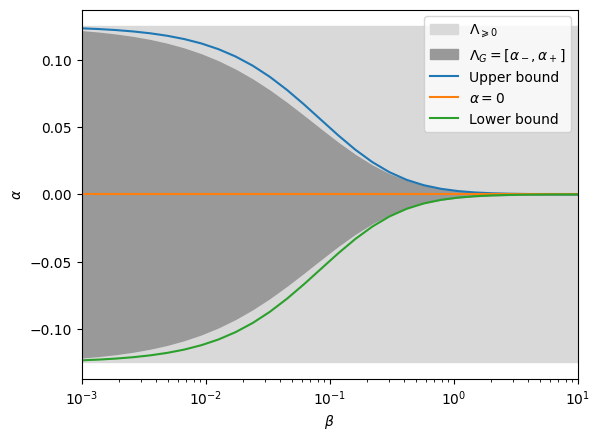

In [34]:
plt.fill_between(
    β_vect,
    -1 / 8 * np.ones(n_points),
    1 / 8 * np.ones(n_points),
    label="$\\Lambda_{\\geqslant 0}$",
    color=[0.85, 0.85, 0.85, 1],
)
plt.fill_between(
    β_vect,
    -res,
    res,
    label="$\\Lambda_G = [\\alpha_-, \\alpha_+]$",
    color=[0.6, 0.6, 0.6, 1],
)

plt.semilogx(β_vect, ubi, label="Upper bound")
plt.semilogx(β_vect, np.zeros(n_points), label="$\\alpha=0$")
plt.semilogx(β_vect, lbi, label="Lower bound")

plt.xlabel("$\\beta$")
plt.ylabel("$\\alpha$")
plt.legend()
plt.xlim([β_vect[0], β_vect[-1]])
plt.show()

### Fish graph

The Fish graph, with properly designed arrival rates, is a counter-example to the lack of flexibility of greedy policies in surjective-only graphs, as it is feasible for a family of greedy policies to converge to the vertex. There, however, a price to pay in terms of delay, despite the fact that the vertex is bijective.

Here is the graph:

In [35]:
fish = sm.KayakPaddle(
    3, 0, 4, names=[str(i) for i in range(1, 7)], rates=[4, 4, 3, 2, 3, 2]
)
fish.show_kernel(disp_rates=False, disp_flow=True)

Our target is the bijective vertex $\alpha=1/2$.

In [36]:
fish.show_flow(disp_rates=False, flow=fish.kernel_to_edge([1/2]))

#### Rate limitation lemma

To build the policy, the first part consists in noticing that if nodes 3 is forced to prioritize the *tail* of the fish (nodes 1 and 2), then the rate that 3 can send to the *body* is at most $9/11\approx 0.818$. This result does not depend on the body shape so we heck it on a simple frying pan (the body reduced to one node outside of 3).

In [37]:
paw = sm.Tadpole(names=[str(i) for i in range(1, 5)], rates=[4, 4, 3, 1])
paw.stabilizable

True

In [38]:
paw.base_flow

array([3., 1., 1., 1.])

In [39]:
paw.run("priority", weights=[0, 1, 1, 0], max_queue=10**7, n_steps=10**7)

True

In [40]:
paw.show_flow(disp_rates=False)

#### Unstable greedy policy lemma

Building on the rate limitation, one can craft an instable greedy policy that *starves* the body of the fish. Starvation induces a constantly growing number of waiting items. Using priorities, we can shape the policy so that waiting items are mostly of type 4. As a side-effect, that would nullify the edge $(3, 6)$, which is what we want.

In [41]:
fish.run("priority", weights=[0, 3, 3, 2, 0, 0, 2], max_queue=10**7, n_steps=10**7, seed=42)
fish.show_flow(disp_rates=False)

We can check that the queue is concentrated on node 4.

In [42]:
fish.simulator.avg_queues

array([8.51466300e-01, 8.47361100e-01, 2.00000000e-07, 5.01960123e+04,
       3.00000000e-07, 1.98790250e+00])

To finalize, all what we need is relax the unstable greedy policy into a stable policy when queues are too high.

In [43]:
fish.run(
    "priority",
    weights=[0, 3, 3, 2, 0, 0, 2],
    threshold=100,
    counterweights=[0, 1, 1, 2, 0, 0, 2],
    n_steps=10**7,
    seed=42
)
fish.show_flow(disp_rates=False)

#### Evaluation

As often, we have a delay/regret trade-off.

In [44]:
rewards = [2, 2, 2, 1, -1, 0, 1]
t_range = Iterator("threshold", 2 ** (np.arange(14)), "k")
name = '$\\Phi_k^+$'
fish_policies = {name: {'simulator': 'priority', 'weights': [0, 3, 3, 2, 0, 0, 2],
                                'counterweights': [0, 1, 1, 2, 0, 0, 2], 'iterator': t_range},
                 'Taboo': specific['Taboo']}

:::note
The priority policy has no built-in regret management, so we need to post-compute it.
:::

In [45]:
fish.simulator = None
xps = xp_builder({'model': fish, **common}, fish_policies)
with Pool() as p:
    res = evaluate(xps, pool=p, metrics=["delay", "regret", "flow"], cache_name="fish", 
                   cache_overwrite=refresh)
    

In [46]:
def regret(model, flow, rewards):    
    original_rates = model.rates
    model.rates = model.incidence @ flow
    best_flow = model.optimize_rates(rewards)
    model.rates = original_rates
    return rewards @ (best_flow - flow)

In [47]:
res[name]['regret'] = [regret(fish, flow, rewards) for flow in res[name]['flow']]

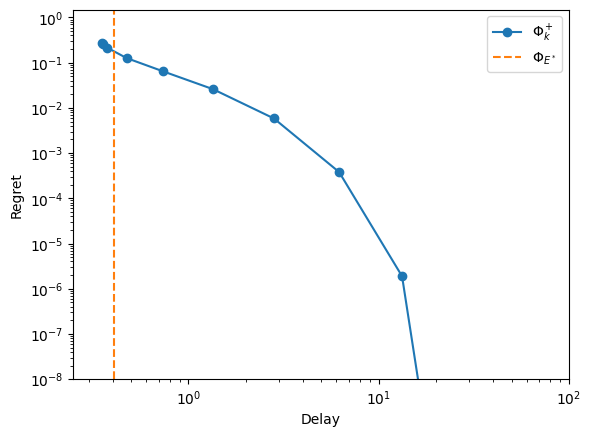

In [48]:
display_res(res, x_max=100, y_max=1.5)